
=== Running dataset: Z-score_normalised_with_lags ===
  - CO(GT), horizon 1h
  - CO(GT), horizon 6h
  - CO(GT), horizon 12h
  - CO(GT), horizon 24h
  - NMHC(GT), horizon 1h
  - NMHC(GT), horizon 6h
  - NMHC(GT), horizon 12h
  - NMHC(GT), horizon 24h
  - C6H6(GT), horizon 1h
  - C6H6(GT), horizon 6h
  - C6H6(GT), horizon 12h
  - C6H6(GT), horizon 24h
  - NOx(GT), horizon 1h
  - NOx(GT), horizon 6h
  - NOx(GT), horizon 12h
  - NOx(GT), horizon 24h
  - NO2(GT), horizon 1h
  - NO2(GT), horizon 6h
  - NO2(GT), horizon 12h
  - NO2(GT), horizon 24h

=== Running dataset: denormalised_with_lags ===
  - CO(GT), horizon 1h
  - CO(GT), horizon 6h
  - CO(GT), horizon 12h
  - CO(GT), horizon 24h
  - NMHC(GT), horizon 1h
  - NMHC(GT), horizon 6h
  - NMHC(GT), horizon 12h
  - NMHC(GT), horizon 24h
  - C6H6(GT), horizon 1h
  - C6H6(GT), horizon 6h
  - C6H6(GT), horizon 12h
  - C6H6(GT), horizon 24h
  - NOx(GT), horizon 1h
  - NOx(GT), horizon 6h
  - NOx(GT), horizon 12h
  - NOx(GT), horizon 24h
  - NO

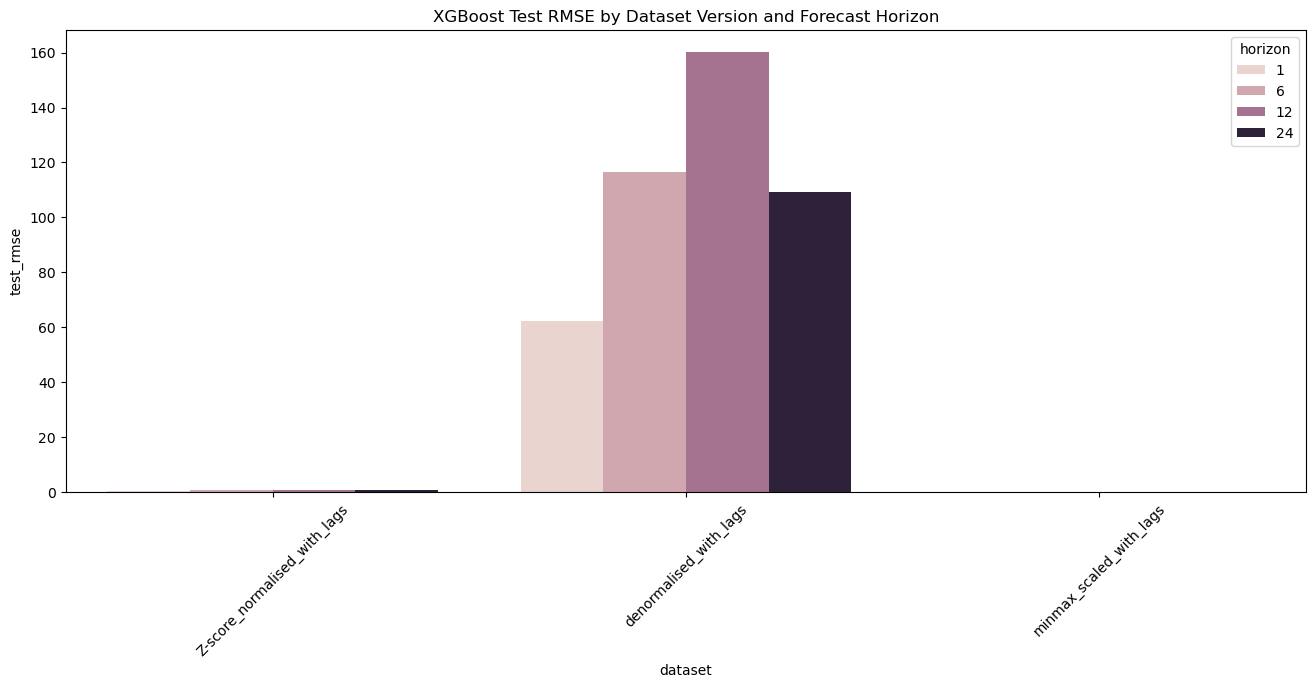

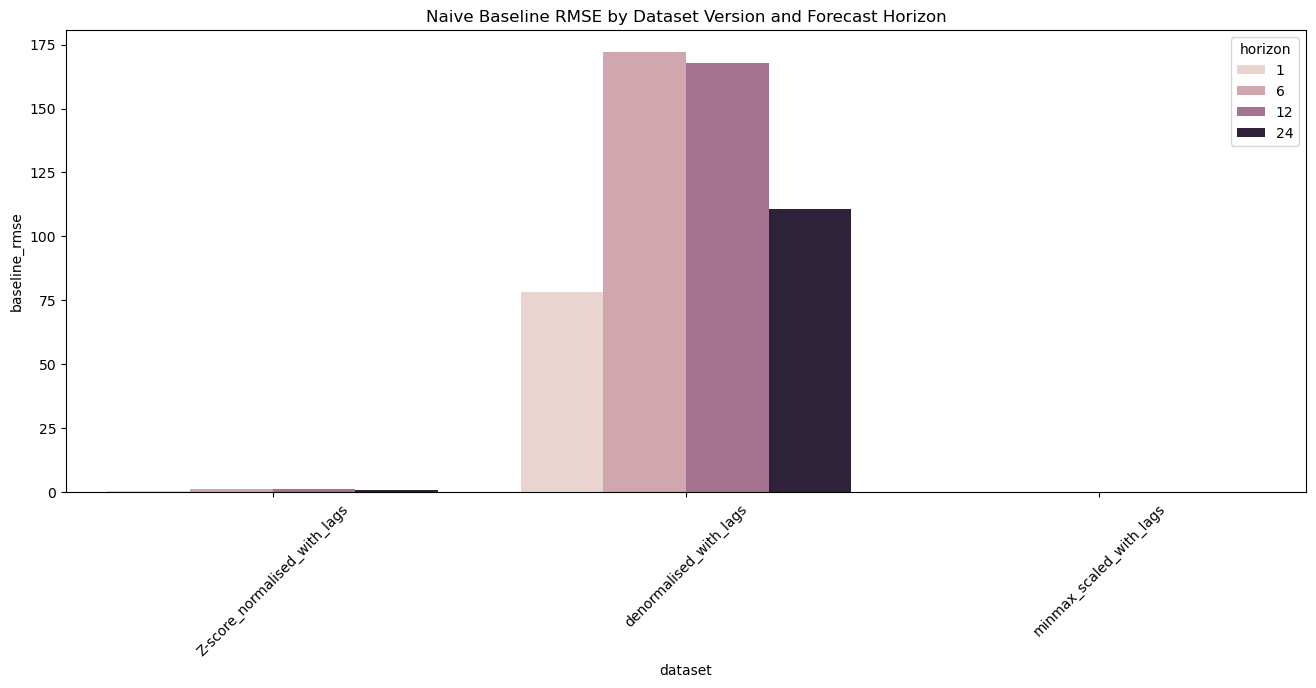


=== Best Dataset Per Pollutant × Horizon (XGBoost) ===
                                   dataset pollutant  horizon  \
pollutant horizon                                               
C6H6(GT)  1        minmax_scaled_with_lags  C6H6(GT)        1   
          6        minmax_scaled_with_lags  C6H6(GT)        6   
          12       minmax_scaled_with_lags  C6H6(GT)       12   
          24       minmax_scaled_with_lags  C6H6(GT)       24   
CO(GT)    1        minmax_scaled_with_lags    CO(GT)        1   
          6        minmax_scaled_with_lags    CO(GT)        6   
          12       minmax_scaled_with_lags    CO(GT)       12   
          24       minmax_scaled_with_lags    CO(GT)       24   
NMHC(GT)  1        minmax_scaled_with_lags  NMHC(GT)        1   
          6        minmax_scaled_with_lags  NMHC(GT)        6   
          12       minmax_scaled_with_lags  NMHC(GT)       12   
          24       minmax_scaled_with_lags  NMHC(GT)       24   
NO2(GT)   1        minmax_scaled_w

In [2]:
import os
import re
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from polars.selectors import numeric
import itertools

# -----------------------------------------------------------
# Configuration
# -----------------------------------------------------------
DATA_DIR = "./9417_imputed_data/"
PLOT_DIR = "XGBoost_plots"
FI_DIR = "feature_importance_data"
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(FI_DIR, exist_ok=True)

DATASETS = {
    "Z-score_normalised_with_lags": "Z-score normalised, with lags.parquet",
    "denormalised_with_lags": "denormalised, with lags.parquet",
    "minmax_scaled_with_lags": "min-max scaled, with lags.parquet",
}

TARGET_COLS = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
HORIZONS = [1, 6, 12, 24]

XGB_PARAM_GRID = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [250],
    "subsample": [0.9],
    "colsample_bytree": [0.9],
}

results = []
agg_fi_rows = []

# -----------------------------------------------------------
# Helper functions
# -----------------------------------------------------------
def clean_name(c):
    return re.sub(r"[^A-Za-z0-9_]", "_", c)

def make_horizon_shift(df, target_col, horizon_h):
    return df.with_columns(
        pl.col(target_col)
        .shift(-horizon_h)
        .alias(f"{target_col}_h{horizon_h}")
    )

def build_expanding_cv(train_size, n_splits=4):
    fold_size = train_size // (n_splits + 1)
    splits = []
    
    for i in range(1, n_splits + 1):
        tr_end = i * fold_size
        val_start = tr_end
        val_end = min(tr_end + fold_size, train_size)
        if val_start >= train_size:
            break
        splits.append((np.arange(0, tr_end), np.arange(val_start, val_end)))
        
    return splits

def get_base_variable(name):
    return name.split("_lag")[0]

# -----------------------------------------------------------
# Main loop
# -----------------------------------------------------------
for version_name, filename in DATASETS.items():
    print(f"\n=== Running dataset: {version_name} ===")

    df = pl.read_ipc(os.path.join(DATA_DIR, filename))
    df = df.sort("DateTime")

    dt_years = pd.to_datetime(df["DateTime"].to_numpy()).year

    idx2004 = np.where(dt_years == 2004)[0]
    idx2005 = np.where(dt_years == 2005)[0]

    if len(idx2004) == 0 or len(idx2005) == 0:
        raise RuntimeError("Expected both 2004 and 2005 rows")

    # -----------------------------------------------------------
    # Loop pollutant × horizon
    # -----------------------------------------------------------
    for pollutant in TARGET_COLS:
        for horizon in HORIZONS:
            print(f"  - {pollutant}, horizon {horizon}h")

            # Shift target forward by the horizon
            df_shifted = make_horizon_shift(df, pollutant, horizon)

            y_col = f"{pollutant}_h{horizon}"

            # Drop rows where shifted target is null
            df_shifted = df_shifted.drop_nulls(subset=[y_col])
            
            # Select numeric columns + DateTime
            df_numeric = (
                df_shifted
                .with_columns(pl.col("DateTime"))
                .select(numeric() | pl.col("DateTime"))
            )
            
            # Rename columns after selecting
            df_numeric = df_numeric.rename(clean_name)
            
            y_col_clean = clean_name(y_col)
            if y_col_clean not in df_numeric.columns:
                print("DEBUG AVAILABLE COLS:", df_numeric.columns)
                raise RuntimeError(f"Target column {y_col_clean} missing after renaming")
            
            # Extract y
            y = df_numeric[y_col_clean].to_numpy()
            
            # Compute years aligned to df_numeric rows
            dt_numeric_years = pd.to_datetime(df_numeric["DateTime"].to_numpy()).year
            idx2004_num = np.where(dt_numeric_years == 2004)[0]
            idx2005_num = np.where(dt_numeric_years == 2005)[0]
            
            # Final X matrix
            X = df_numeric.drop(y_col_clean).drop("DateTime").to_pandas()

            if len(idx2004_num) == 0 or len(idx2005_num) == 0:
                continue

            # Training and validation split within 2004
            N2004_num = len(idx2004_num)
            train_cut = int(0.85 * N2004_num)

            tr_start = idx2004_num[0]
            tr_end = tr_start + train_cut

            # Build expanding CV
            total_train_len = tr_end - tr_start
            cv_raw = build_expanding_cv(total_train_len, n_splits=4)

            cv_splits = [(tr_rel + tr_start, val_rel + tr_start) for tr_rel, val_rel in cv_raw]

            # ---------------------------------------------------------
            # Hyperparameter tuning
            # ---------------------------------------------------------
            best_rmse = float("inf")
            best_params = None

            for combo in itertools.product(*XGB_PARAM_GRID.values()):
                params = dict(zip(XGB_PARAM_GRID.keys(), combo))
                rmses = []

                for tr_idx, val_idx in cv_splits:
                    model = XGBRegressor(
                        objective="reg:squarederror",
                        eval_metric="rmse",
                        tree_method="hist",
                        n_jobs=-1,
                        **params
                    )
                    model.fit(X.iloc[tr_idx], y[tr_idx])
                    preds = model.predict(X.iloc[val_idx])
                    rmses.append(root_mean_squared_error(y[val_idx], preds))

                avg_rmse = np.mean(rmses)
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_params = params

            # ---------------------------------------------------------
            # Train final model
            # ---------------------------------------------------------
            final_model = XGBRegressor(
                objective="reg:squarederror",
                eval_metric="rmse",
                tree_method="hist",
                n_jobs=-1,
                **best_params
            )
            final_model.fit(X.iloc[idx2004_num], y[idx2004_num])

            # ---------------------------------------------------------
            # Test evaluation
            # ---------------------------------------------------------
            y_test = y[idx2005_num]
            test_preds = final_model.predict(X.iloc[idx2005_num])
            test_rmse = root_mean_squared_error(y_test, test_preds)

            # ---------------------------------------------------------
            # Naive baseline (properly aligned)
            # ---------------------------------------------------------
            shifted_idx = idx2005_num - horizon
            valid_mask = shifted_idx >= 0

            baseline_preds = y[shifted_idx[valid_mask]]
            baseline_truth = y_test[valid_mask]

            baseline_rmse = root_mean_squared_error(baseline_truth, baseline_preds)

            # ---------------------------------------------------------
            # Feature importance (Gain)
            # ---------------------------------------------------------
            booster = final_model.get_booster()
            raw_fi = booster.get_score(importance_type="gain")

            # Convert dict to DataFrame
            fi_df = pd.DataFrame({
                "feature": list(raw_fi.keys()),
                "importance_gain": list(raw_fi.values()),
            }).sort_values("importance_gain", ascending=False)

            # Save raw FI
            fi_path = os.path.join(
                FI_DIR,
                f"XGB_FeatureImportance_{version_name}_{pollutant}_h{horizon}.csv"
            )
            fi_df.to_csv(fi_path, index=False)

            # Aggregated FI by base variable
            fi_df["base_variable"] = fi_df["feature"].apply(get_base_variable)
            agg_df = (
                fi_df.groupby("base_variable")["importance_gain"]
                .sum()
                .reset_index()
                .sort_values("importance_gain", ascending=False)
            )

            # Accumulate for master CSV
            for _, row in agg_df.iterrows():
                agg_fi_rows.append({
                    "dataset": version_name,
                    "pollutant": pollutant,
                    "horizon": horizon,
                    "base_variable": row["base_variable"],
                    "importance_sum_gain": row["importance_gain"],
                })

            # ---------------------------------------------------------
            # Diagnostic plots
            # ---------------------------------------------------------
            base_name = f"{version_name}_{pollutant}_h{horizon}"

            # 1. Prediction vs Actual scatter
            plt.figure(figsize=(6, 6))
            plt.scatter(y_test, test_preds, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()],
                     [y_test.min(), y_test.max()], "k--")
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title(f"{version_name} | {pollutant} | h={horizon}h\nScatter")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_scatter.png")
            plt.close()

            # 2. Residuals over time
            residuals = test_preds - y_test
            plt.figure(figsize=(12, 4))
            plt.plot(residuals)
            plt.title(f"{version_name} | {pollutant} | h={horizon}h\nResiduals Over Time")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_residuals.png")
            plt.close()

            # 3. Residual histogram
            plt.figure(figsize=(6, 4))
            sns.histplot(residuals, bins=40, kde=True)
            plt.title(f"{version_name} | {pollutant} | h={horizon}h\nResidual Histogram")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_resid_hist.png")
            plt.close()

            # 4. Actual vs predicted (time series)
            plt.figure(figsize=(14, 4))
            plt.plot(y_test, label="Actual")
            plt.plot(test_preds, label="Predicted")
            plt.legend()
            plt.title(f"{version_name} | {pollutant} | h={horizon}h\nTime Series Comparison")
            plt.tight_layout()
            plt.savefig(f"{PLOT_DIR}/{base_name}_timeseries.png")
            plt.close()

            # ---------------------------------------------------------
            # Save all scores
            # ---------------------------------------------------------
            results.append({
                "dataset": version_name,
                "pollutant": pollutant,
                "horizon": horizon,
                "best_params": str(best_params),
                "val_rmse": best_rmse,
                "test_rmse": test_rmse,
                "baseline_rmse": baseline_rmse,
            })

# -----------------------------------------------------------
# Save results
# -----------------------------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgboost_temporal_final.csv", index=False)
print("\nSaved results to xgboost_temporal_final.csv")
print(results_df)

# -----------------------------------------------------------
# Save master aggregated FI CSV
# -----------------------------------------------------------
agg_df_master = pd.DataFrame(agg_fi_rows)
agg_path = os.path.join(FI_DIR, "XGB_AggregatedImportance_MASTER.csv")
agg_df_master.to_csv(agg_path, index=False)

print(f"\nSaved XGB aggregated FI to {agg_path}")
print(agg_df_master.head())

# -----------------------------------------------------------
# Summary plots
# -----------------------------------------------------------
plt.figure(figsize=(16, 6))
sns.barplot(data=results_df, x="dataset", y="test_rmse", hue="horizon", errorbar=None)
plt.xticks(rotation=45)
plt.title("XGBoost Test RMSE by Dataset Version and Forecast Horizon")
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=results_df, x="dataset", y="baseline_rmse", hue="horizon", errorbar=None)
plt.xticks(rotation=45)
plt.title("Naive Baseline RMSE by Dataset Version and Forecast Horizon")
plt.show()

# -----------------------------------------------------------
# Best dataset summary
# -----------------------------------------------------------
best_table = (
    results_df
    .groupby(["pollutant", "horizon"])["test_rmse"]
    .idxmin()
    .apply(lambda idx: results_df.loc[idx])
)

print("\n=== Best Dataset Per Pollutant × Horizon (XGBoost) ===")
print(best_table)
